In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
from scipy.sparse import csr_matrix
import sklearn
import gget
import scanpy.external as sce

sc.settings.verbosity = 3  

In [2]:
paths = {
    "iHSC" : "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/analysis.anndata.h5ad",
    "scFib" : "/scratch/indikar_root/indikar1/shared_data/single_cell_fibroblast/scanpy/processed.anndata.h5ad",
}

adatas = {}

for key, fpath in paths.items():
    adata = sc.read_h5ad(fpath)
    
    adata.obs['dataset'] = key
    sc.logging.print_memory_usage()
    
    adata.var = adata.var[['gene_name']]
    keep_cols = [
        'cluster_str', 
        'dataset',
        'leiden',   
        'pred_phase',
    ]
    
    column_mask = [x for x in adata.obs.columns if x in keep_cols]
    adata.obs = adata.obs[column_mask]
    
    if 'counts' in 'counts' in adata.layers.keys():
        adata.X = csr_matrix(adata.layers['counts'])
    else:
        adata.X = csr_matrix(adata.layers['raw_counts'])
        
    layers = list(adata.layers.keys())
    for layer in layers:
        del adata.layers[layer]
    
    del adata.obsm
    del adata.obsp
    del adata.varm
    
    sc.pp.filter_genes(adata, min_cells=20)
    
    adatas[key] = adata
    
    print(adata)
    print()


adata = an.concat(
    adatas, 
    axis=0, # align on obs
    label='dataset', 
    index_unique="_", 
    join="outer",
    merge='same',
)

sc.logging.print_memory_usage()

adata

Memory usage: current 2.84 GB, difference +2.84 GB
filtered out 1826 genes that are detected in less than 20 cells
AnnData object with n_obs × n_vars = 8563 × 13239
    obs: 'cluster_str', 'dataset'
    var: 'gene_name', 'n_cells'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'

Memory usage: current 2.70 GB, difference -0.14 GB
filtered out 1212 genes that are detected in less than 20 cells
AnnData object with n_obs × n_vars = 7748 × 12870
    obs: 'pred_phase', 'leiden', 'dataset'
    var: 'gene_name', 'n_cells'
    uns: 'diffmap_evals', 'hvg', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'pred_phase_colors', 'rank_genes_groups', 'umap'

Memory usage: current 1.38 GB, difference -1.33 GB


AnnData object with n_obs × n_vars = 16311 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden'

In [3]:
# filtration
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)

adata.layers["counts"] = csr_matrix(adata.X.astype('float32').copy())

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=["mt", "ribo", "hb"], 
    log1p=False,
    inplace=True,
)

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["norm"] = csr_matrix(adata.X.astype('float32').copy())
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

# combat
sc.pp.combat(
    adata, 
    key='dataset',
    covariates=['total_counts', 'n_genes'],
)

adata.X = csr_matrix(adata.X.astype('float32'))

adata.layers["combat"] = adata.X.copy()

# set current layer
adata.X = adata.layers["combat"]

# magic on combat corrected
sce.pp.magic(
    adata,
    name_list='all_genes',
    solver='exact',
    copy=False,
)

adata.layers["magic"] = csr_matrix(adata.X.astype('float32').copy())

""" SET CURRENT LAYER TO COMBAT """
adata.X = adata.layers["combat"] 

adata

filtered out 181 cells that have less than 500 genes expressed
normalizing counts per cell
    finished (0:00:00)
Standardizing Data across genes.

Found 2 batches

Found 2 numerical variables:
	total_counts, n_genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data

computing MAGIC
  Running MAGIC with `solver='exact'` on 13579-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
    finished (0:03:02)


AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts', 'norm', 'log_norm', 'combat', 'magic'

extracting highly variable genes
    finished (0:00:11)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:10)


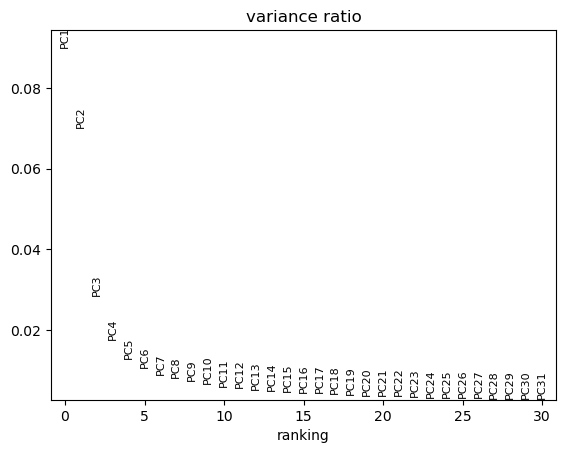

In [4]:
sc.pp.highly_variable_genes(
    adata,
    batch_key='dataset',
)

sc.tl.pca(
    adata,
    mask_var='highly_variable',
)

sc.pl.pca_variance_ratio(adata)

In [5]:
sce.pp.scanorama_integrate(
    adata,
    key='dataset',
    verbose=3,
    knn=35,
    sigma=35,
)

adata.obsm['X_scanorama'].shape

[[0.         0.74638616]
 [0.         0.        ]]
Processing datasets iHSC <=> scFib


(16130, 50)

In [6]:
sc.pp.neighbors(
    adata,
    n_neighbors=25,
)
sc.tl.umap(
    adata,
    # min_dist=0.3,
)
sc.tl.leiden(
    adata, 
    resolution=0.5, 
    key_added='new_cluster',
)
adata

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)
running Leiden clustering


/tmp/ipykernel_1815472/2404615062.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 9 clusters and added
    'new_cluster', the cluster labels (adata.obs, categorical) (0:00:02)


AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'new_cluster'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm', 'log_norm', 'combat', 'magic'
    obsp: 'distances', 'connectivities'

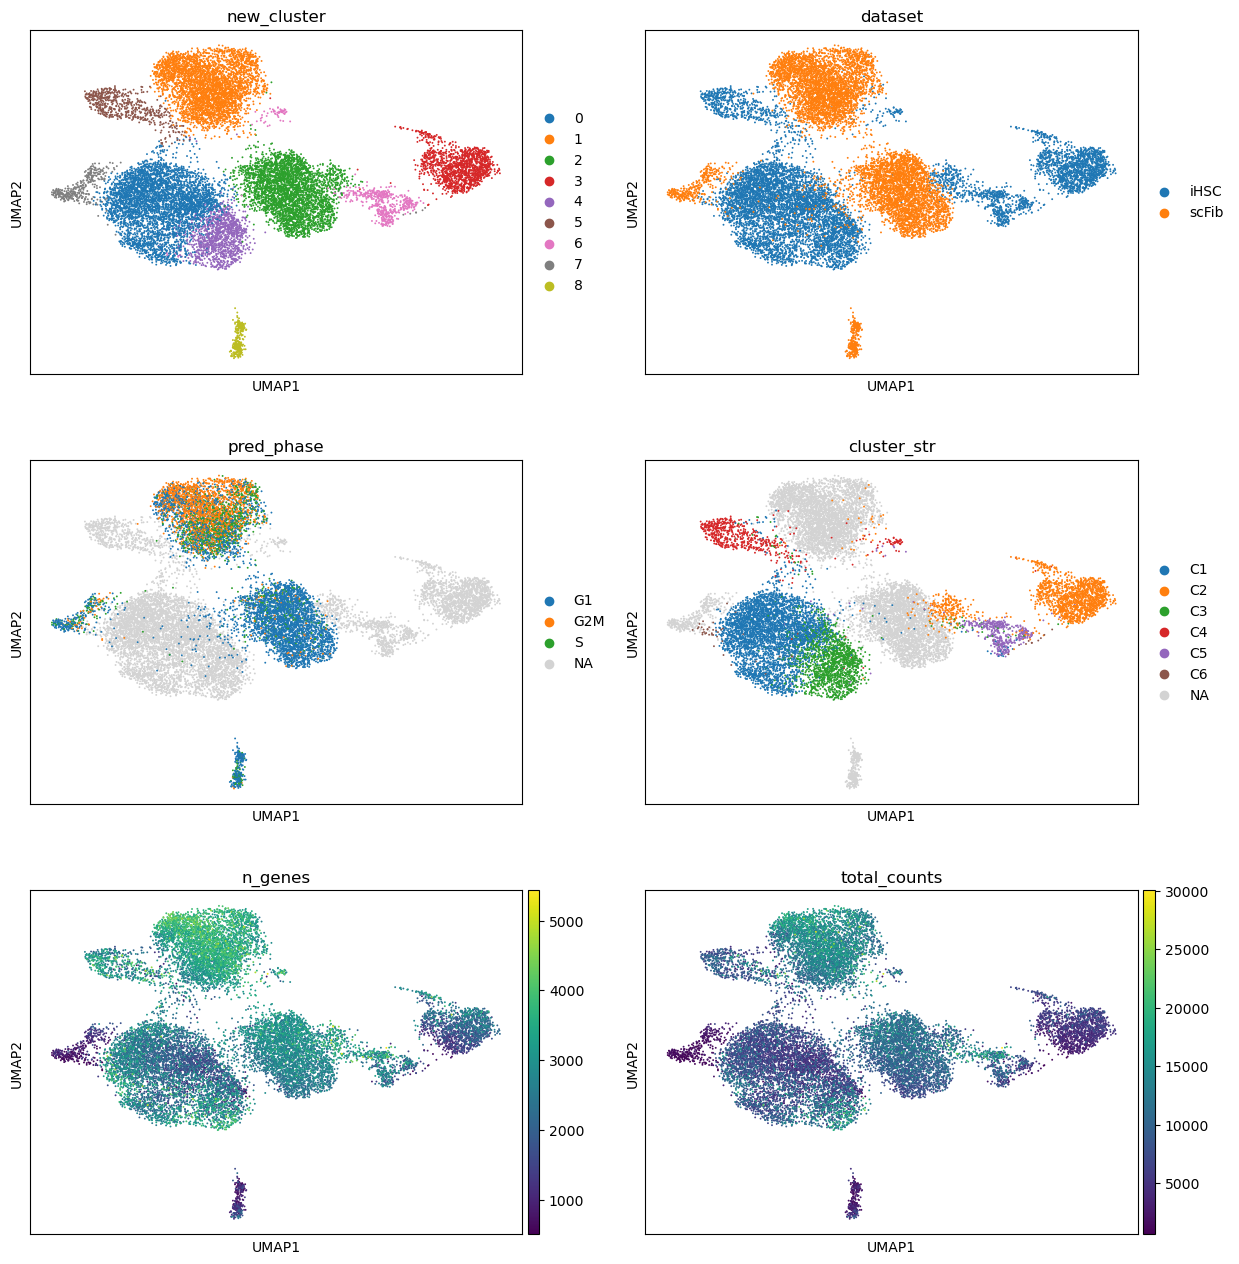

In [7]:
sc.pl.umap(
    adata,
    color=[
        'new_cluster', 
        'dataset',
        'pred_phase', 
        'cluster_str',
        'n_genes',
        'total_counts',
    ],
    ncols=2,
)

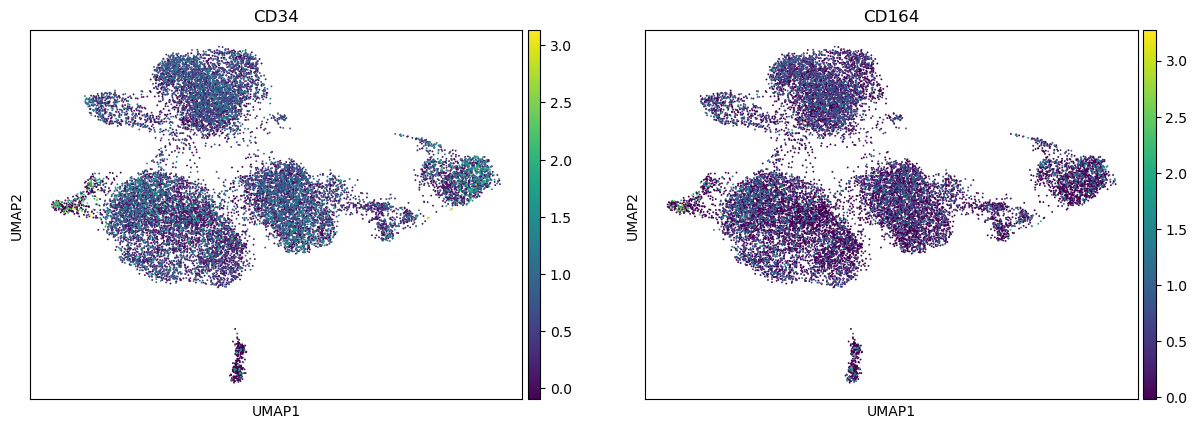

In [8]:
sc.pl.umap(
    adata,
    color=[
        'CD34',
        'CD164',
    ],
    layer='combat',
    ncols=2,
)

In [9]:
outpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/merged_scfib.h5ad"
adata.write(outpath)

adata

AnnData object with n_obs × n_vars = 16130 × 13579
    obs: 'cluster_str', 'dataset', 'pred_phase', 'leiden', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'new_cluster'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'new_cluster', 'new_cluster_colors', 'dataset_colors', 'pred_phase_colors', 'cluster_str_colors'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm', 'log_norm', 'combat', 'magic'
    obsp: 'distances', 'connectivities'